# Load and import

In [80]:
%run load_data.ipynb
print (dir())

{0: 3356849, 1: 47, 2: 159, 4: 885653, 67108864: 93686, 134217728: 28959}
{0: 4290039, 1: 45, 2: 349, 4: 1627, 67108864: 16092, 134217728: 29906}
0
1
10
100
100000000000000000000000000
1000000000000000000000000000
['DataFrame', 'G_INDEX', 'In', 'Math', 'NPIX', 'NSIDE', 'Out', 'SIZE_RATIO_CUT', 'SNR_CUT', 'Series', 'T_CUT', 'Table', '_', '_14', '_15', '_68', '_69', '_72', '_73', '_74', '_75', '_76', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i21', '_i22', '_i23', '_i24', '_i25', '_i26', '_i27', '_i28', '_i29', '_i3', '_i30', '_i31', '_i32', '_i33', '_i34', '_i35', '_i36', '_i37', '_i38', '_i39', '_i4', '_i40', '_i41', '_i42', '_i43', '_i44', '_i45', '_i46', '_i47', '_i48', '_i49', '_i5', '_i50', '_i51', '_i52', '_i53', '_i54', '_i55', '_i56', '_i57', '_i58', '_i59', '_i6', '_i60', '_i61', '_i62', '_i63', '_i

### read gold dfs (gold maps and delta_g)

In [81]:
g_gold_list_positive=[None]*4
for i in range(4):
    path='/home/cz136/project/balrog/data/gold_g/mcal{}.pkl'.format(i+2)
    g_gold_list_positive[i]=pd.read_pickle(path)

### read gold maps

In [82]:
gold_all=pd.read_pickle('/home/cz136/project/balrog/data/gold_g/gold.pkl')

In [83]:
import treecorr
import numpy as np
import pandas as pd
import healpy as hp
from tqdm import tqdm

pd.set_option('display.float_format', lambda x: '%.3e' % x)
np.set_printoptions(formatter={'all':lambda x: '%.3e'% x})

# Constants

In [84]:
NSIDE=256 #or 512
NPIX=hp.nside2npix(NSIDE)
print ("The number of pixels is: {}.".format(NPIX))
G_INDEX=np.arange(NPIX)

The number of pixels is: 786432.


# data manipulating

### get an df with nan rows dropped

In [85]:
gold_all_not_null=gold_all[gold_all['ebv_planck13'].notnull()]
# g_gold_list_negative_not_null=[df[df['ebv_planck13'].notnull()] for df in g_gold_list_negative]

In [86]:
gold_columns=list(gold_all_not_null.columns)[:-8]

In [87]:
final_df_positive_list=[None]*4
for i,catalog in enumerate(mcal_df_list_positive):
    final_df_positive_list[i]=pd.concat([catalog,photdf[['true_cm_g_1','true_cm_g_2']]],axis=1,join='inner')

In [88]:
final_df_negative_list=[None]*4
for i,catalog in enumerate(mcal_df_list_negative):
    final_df_negative_list[i]=pd.concat([catalog,photdf[['true_cm_g_1','true_cm_g_2']]],axis=1,join='inner')

### function for get delta_g columns

In [89]:
def get_delta_g(catalog):
    R11 = catalog['R11'].mean()
    R22 = catalog['R22'].mean()
    catalog['calculated_g_1']=catalog.apply(lambda x:x['e_1']/R11,axis=1)
    catalog['calculated_g_2']=catalog.apply(lambda x:x['e_2']/R22,axis=1)
    catalog['delta_g1']=catalog.apply(lambda x:x['calculated_g_1']-x['true_cm_g_1'],axis=1)
    catalog['delta_g2']=catalog.apply(lambda x:x['calculated_g_2']-x['true_cm_g_2'],axis=1)

In [90]:
for catalog in final_df_positive_list:
    get_delta_g(catalog)
for catalog in final_df_negative_list:
    get_delta_g(catalog)

### function to get correlation functions

In [91]:
def get_gg(catalog):
    print(len(catalog))
    delta_g1=catalog['delta_g1'].to_numpy()
    delta_g2=catalog['delta_g2'].to_numpy()
    ra=catalog['ra'].to_numpy()
    dec=catalog['dec'].to_numpy()
    
    scat = treecorr.Catalog( g1 = delta_g1, g2   = delta_g2, 
                                 ra = ra, dec  = dec, 
                                 ra_units='deg', dec_units='deg')
    
    gg = treecorr.GGCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.2)
    gg.process(scat)
    
    gg_dict={'gg':gg, 'length':len(catalog), 'g1avg':np.mean(catalog['delta_g1']), 'g2avg':np.mean(catalog['delta_g2']),
                'g1sigma':np.std(catalog['delta_g1']),'g2sigma':np.std(catalog['delta_g2'])}
    
    return(gg_dict)

In [92]:
def get_kg(catalog,key):
    delta_g1=catalog['delta_g1'].to_numpy()
    delta_g2=catalog['delta_g2'].to_numpy()
    k=catalog[key].to_numpy()
    ra=catalog['ra'].to_numpy()
    dec=catalog['dec'].to_numpy()
    
    kcat= treecorr.Catalog( k=k,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    gcat = treecorr.Catalog( g1=delta_g1, g2=delta_g2,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    kg = treecorr.KGCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.2)
    kg.process(kcat,gcat)
    return(kg)

In [93]:
gg_positive = [get_gg(catalog) for catalog in final_df_positive_list]
gg_negative = [get_gg(catalog) for catalog in final_df_negative_list]

272818
272818
215145
215145
270876
270876
213617
213617


### function for getting healpix indexes

In [94]:
def get_healpix(df):
    print ("The length of the df is: {}.".format(len(df)))
    print ("The ratio of the length of the catagory to the total pixel number is: {:.2%}".format(len(df)/NPIX))
    df['ipix']=df.apply(lambda x:hp.ang2pix(NSIDE,np.pi/2-np.deg2rad(x['dec']),np.deg2rad(x['ra']),nest=True),axis=1)
    print("The propotion of rendered objects is: {:.2%}".format(np.sum(df['ipix']!=0)/len(df)))
    return (df)

In [95]:
df_w_ipix = [get_healpix(df) for df in final_df_list]

The length of the df is: 1098637.
The ratio of the length of the catagory to the total pixel number is: 139.70%
The propotion of rendered objects is: 100.00%
The length of the df is: 1098637.
The ratio of the length of the catagory to the total pixel number is: 139.70%
The propotion of rendered objects is: 100.00%
The length of the df is: 867808.
The ratio of the length of the catagory to the total pixel number is: 110.35%
The propotion of rendered objects is: 100.00%
The length of the df is: 867808.
The ratio of the length of the catagory to the total pixel number is: 110.35%
The propotion of rendered objects is: 100.00%


In [96]:
df_w_ipix_positive=[get_healpix(df) for df in final_df_positive_list]
df_w_ipix_negative=[get_healpix(df) for df in final_df_negative_list]

The length of the df is: 272818.
The ratio of the length of the catagory to the total pixel number is: 34.69%
The propotion of rendered objects is: 100.00%
The length of the df is: 272818.
The ratio of the length of the catagory to the total pixel number is: 34.69%
The propotion of rendered objects is: 100.00%
The length of the df is: 215145.
The ratio of the length of the catagory to the total pixel number is: 27.36%
The propotion of rendered objects is: 100.00%
The length of the df is: 215145.
The ratio of the length of the catagory to the total pixel number is: 27.36%
The propotion of rendered objects is: 100.00%
The length of the df is: 270876.
The ratio of the length of the catagory to the total pixel number is: 34.44%
The propotion of rendered objects is: 100.00%
The length of the df is: 270876.
The ratio of the length of the catagory to the total pixel number is: 34.44%
The propotion of rendered objects is: 100.00%
The length of the df is: 213617.
The ratio of the length of the 

In [97]:
#index for gold map with valid pixels
map_ipix=gold_all_not_null.index.to_numpy()

In [98]:
def fill_gold_values_to_mcal(df):
    ##drop balrog objects that does not have a corresponding gold map healpix index
    drop_mask=np.isin(df['ipix'].to_numpy(),map_ipix)
    df_new=df[drop_mask]
    #index for gold map values
    gold_index=df_new['ipix'].to_numpy()
    #balrog indexes for df_new
    bal_index=df_new.index
#     print(gold_index)
#     print(len(gold_index))
    #get gold values by ipix 
    gold_all_not_null_reindexed=gold_all_not_null.loc[gold_index]
    #reset the index of gold df to balrog index
    gold_all_not_null_reindexeded=gold_all_not_null_reindexed.set_index(bal_index)
#     print(len(df_new),len(gold_all_not_null_reindexeded))
#     df_new_joined=pd.concat([df_new,gold_all_not_null_reindexed],axis=1)
    #concatenate gold values with mcal catalogues on balrog index
    joined=pd.concat([df_new,gold_all_not_null_reindexeded],axis=1)
#     print(len(temp))
    return (joined)

In [99]:
filled_df_positive=[fill_gold_values_to_mcal(df) for df in final_df_positive_list]
filled_df_negative=[fill_gold_values_to_mcal(df) for df in final_df_negative_list]

In [100]:
filled_df_list = [fill_gold_values_to_mcal(df) for df in final_df_list]

In [101]:
key_list=gold_all.columns

In [102]:
def get_kg_for_key(key):
    return (lambda df:get_kg(df,key))


In [103]:
def get_kg_for_indi_df(df):
    print(len(df))
    kg_dict={}
    for key in key_list:
        kg_dict[key]={"corrfunc":get_kg_for_key(key)(df),"length":len(df),"kaverage":np.mean(df[key]),"ksigma":np.std(df[key]),
                      'g1avg':np.mean(df['delta_g1']),'g1sigma':np.std(df['delta_g1'])} 
    return(kg_dict)

In [104]:
kg_positive=[get_kg_for_indi_df(df) for df in filled_df_positive]
kg_negative=[get_kg_for_indi_df(df) for df in filled_df_negative]

215727
215727
169940
169940
214531
214531
169167
169167


# Plotting

In [105]:
def plt_gg(gg,title=None):
    corrfunc=gg['gg']
    length = gg['length']
    g1avg = gg['g1avg']
    g2avg = gg['g2avg']
    g1sigma=gg['g1sigma']
    g2sigma=gg['g2sigma']
    
#     gg_dict={'gg':gg, 'length':len(catalog), 'g1avg':np.mean(catalog['delta_g1']), 'g2_avg':np.mean(catalog['delta_g1']),
#                 'g1sigma':np.std(catalog['delta_g1']),'g2sigma':np.std(catalog['delta_g2'])} 
        
    textstr = '\n'.join((
        r'$n=%.2e$' % (length, ),
        r'$g1_{avg}=%.2e$' % (g1avg, ),
        r'$\sigma_{g1}=%.2e$' % (g1sigma, ),
        r'$g2_{avg}=%.2e$' % (g2avg, ),
        r'$\sigma_{g2}=%.2e$' % (g2sigma, )))
    
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    fig,ax = plt.subplots()
    ax.errorbar(np.exp(corrfunc.meanlogr),corrfunc.xip,yerr=np.sqrt(corrfunc.varxip))
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title+'_xip')
    plt.xlabel('$\\theta$/arcmin')
    ax.text(0.80, 0.95, textstr, transform=ax.transAxes, fontsize=5,
            verticalalignment='top', bbox=props)
    plt.savefig('/home/cz136/project/balrog/image/corr/{}_xip'.format(title),dpi=500)
    plt.close()
    
    fig,ax = plt.subplots()
    plt.errorbar(corrfunc.meanlogr,corrfunc.xim,yerr=np.sqrt(corrfunc.varxim))
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title+'_xim')
    plt.xlabel(r"$\theta$ /arcmin")
    ax.text(0.80, 0.95, textstr, transform=ax.transAxes, fontsize=5,
            verticalalignment='top', bbox=props)
    plt.savefig('/home/cz136/project/balrog/image/corr/{}_xim'.format(title),dpi=500)
    plt.close()

In [106]:
def plt_kg(kg,key,title=None):
    corrfunc = kg['corrfunc']
    kavg = kg['kaverage']
    ksig = kg['ksigma']
    length=kg['length']
    g1avg=kg['g1avg']
    g1sigma=kg['g1sigma']
    
    textstr = '\n'.join((
        r'$n=%.2e$' % (length, ),
        r'$\kappa_{avg}=%.2e$' % (kavg, ),
        r'$\sigma_k=%.2e$' % (ksig, ),
        r'$g1_{avg}=%.2e$' % (g1avg, ),
        r'$\sigma_{g1}=%.2e$' % (g1sigma, )))
    
    fig,ax = plt.subplots()
    ax.errorbar(np.exp(corrfunc.meanlogr),corrfunc.xi,yerr=np.sqrt(corrfunc.varxi))
    plt.xscale('log')
    plt.yscale('log')
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axe80808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080808080s coords
    ax.text(0.80, 0.95, textstr, transform=ax.transAxes, fontsize=5,
            verticalalignment='top', bbox=props)
   
    
    plt.title(title)
    plt.xlabel(r"$\theta$ /arcsec")
    plt.savefig('/home/cz136/project/balrog/image/corr/{}'.format(title),dpi=500)
    plt.close()

In [107]:
mcal_str=['riz with MOF', 'riz without MOF', 'griz with MOF', 'griz without MOF']

for i,gg in enumerate(gg_positive):
    plt_gg(gg, title='GG {} e>0'.format(mcal_str[i]))
for i,gg in enumerate(gg_negative):
    plt_gg(gg, title='GG {} e<0'.format(mcal_str[i]))

In [108]:
def plot_indi_kg_dict(kg_dict,title=None):
    for key,value in kg_dict.items():
        plt_kg(value,key,title=title+'_'+str(key))

In [109]:
FONT_SIZE = 6

In [110]:
for i,kg_dict in enumerate(kg_positive):
    plot_indi_kg_dict(kg_dict,title='KG {} e>0'.format(mcal_str[i]))
for i,kg_dict in enumerate(kg_negative):
    plot_indi_kg_dict(kg_dict,title='KG {} e<0'.format(mcal_str[i]))

In [111]:
plt.rcParams['axes.grid'] = True
band_str_list=['riz','griz']
panel_title_list=['w/ MOF, e>0, ', 'w/ MOF, e<0, ', 'wo/ MOF, e>0, ', 'wo/ MOF, e<0, ']

def plt_gg_sub(gg_positive,gg_negative):

    for i in range(2): ## cycle through riz and griz
        pmof=gg_positive[i]
        p=gg_positive[i+1]
        nmof=gg_negative[i]
        n=gg_negative[i+1]
        
        corrfunc=gg['gg']

        
        def get_plt_arguments(gg_dict,mode):
            if mode == "xip":
                return({'x':np.exp(gg_dict['gg'].meanlogr),'y':gg_dict['gg'].xip,'yerr': np.sqrt(gg_dict['gg'].varxip)})
            if mode == "xim":
                return ({'x':np.exp(gg_dict['gg'].meanlogr),'y':gg_dict['gg'].xim,'yerr': np.sqrt(gg_dict['gg'].varxim)})
            
        def get_plt_stats(gg):
            length=gg['length']
            g1avg = gg['g1avg']
            g2avg = gg['g2avg']
            g1sigma=gg['g1sigma']
            g2sigma=gg['g2sigma']
            
                
            textstr = '\n'.join((
                r'$n=%.2e$' % (length, ),
                r'$g1_{avg}=%.2e$' % (g1avg, ),
                r'$\sigma_{g1}=%.2e$' % (g1sigma, ),
                r'$g2_{avg}=%.2e$' % (g2avg, ),
                r'$\sigma_{g2}=%.2e$' % (g2sigma, )))

            return (textstr)
        
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            
        # plot PM NM
        #      P  N
        #   1st xip
        fig, axs = plt.subplots(2,2)
        fig.set_figheight(10)
        fig.set_figwidth(15)
        for j,ax in enumerate(fig.axes):
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_title(r'$\xi_{}(r)$ {} {}'.format('{+}',panel_title_list[j],band_str_list[i],y=0.93))

            
        axs[0,0].errorbar(**get_plt_arguments(pmof,"xip"))
        axs[0,0].text(0.80, 0.95, get_plt_stats(pmof), transform=axs[0,0].transAxes, fontsize=FONT_SIZE,
        verticalalignment='top', bbox=props)
        axs[0,1].errorbar(**get_plt_arguments(nmof,"xip"))
        axs[0,1].text(0.80, 0.95, get_plt_stats(nmof), transform=axs[0,1].transAxes, fontsize=FONT_SIZE,
        verticalalignment='top', bbox=props)
        axs[1,0].errorbar(**get_plt_arguments(p,"xip"))
        axs[1,0].text(0.80, 0.95, get_plt_stats(p), transform=axs[1,0].transAxes, fontsize=FONT_SIZE,
        verticalalignment='top', bbox=props)
        axs[1,1].errorbar(**get_plt_arguments(n,"xip"))
        axs[1,1].text(0.80, 0.95, get_plt_stats(n), transform=axs[1,1].transAxes, fontsize=FONT_SIZE,
        verticalalignment='top', bbox=props)
        plt.subplots_adjust(hspace=0)
        plt.savefig('/home/cz136/project/balrog/image/corr/subplots/GG/GGxip_{}.png'.format(band_str_list[i]),dpi=500)
        plt.close()
        
        
        fig, axs = plt.subplots(2,2)
        fig.set_figheight(10)
        fig.set_figwidth(15)
        for j,ax in enumerate(fig.axes):
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_title(r'$\xi_{}(r)$ {} {}'.format('{-}',panel_title_list[j],band_str_list[i]), y=0.93)
        axs[0,0].errorbar(**get_plt_arguments(pmof,"xim"))
        axs[0,0].text(0.80, 0.95, get_plt_stats(pmof), transform=axs[0,0].transAxes, fontsize=FONT_SIZE,
        verticalalignment='top', bbox=props)
        axs[0,1].errorbar(**get_plt_arguments(nmof,"xim"))
        axs[0,1].text(0.80, 0.95, get_plt_stats(nmof), transform=axs[0,1].transAxes, fontsize=FONT_SIZE,
        verticalalignment='top', bbox=props)
        axs[1,0].errorbar(**get_plt_arguments(p,"xim"))
        axs[1,0].text(0.80, 0.95, get_plt_stats(p), transform=axs[1,0].transAxes, fontsize=FONT_SIZE,
        verticalalignment='top', bbox=props)
        axs[1,1].errorbar(**get_plt_arguments(n,"xim"))
        axs[1,1].text(0.80, 0.95, get_plt_stats(n), transform=axs[1,1].transAxes, fontsize=FONT_SIZE,
        verticalalignment='top', bbox=props)
        plt.subplots_adjust(hspace=0)
        plt.savefig('/home/cz136/project/balrog/image/corr/subplots/GG/GGxim_{}.png'.format(band_str_list[i]),dpi=500)
        plt.close
        
        
#         for ax in axs:

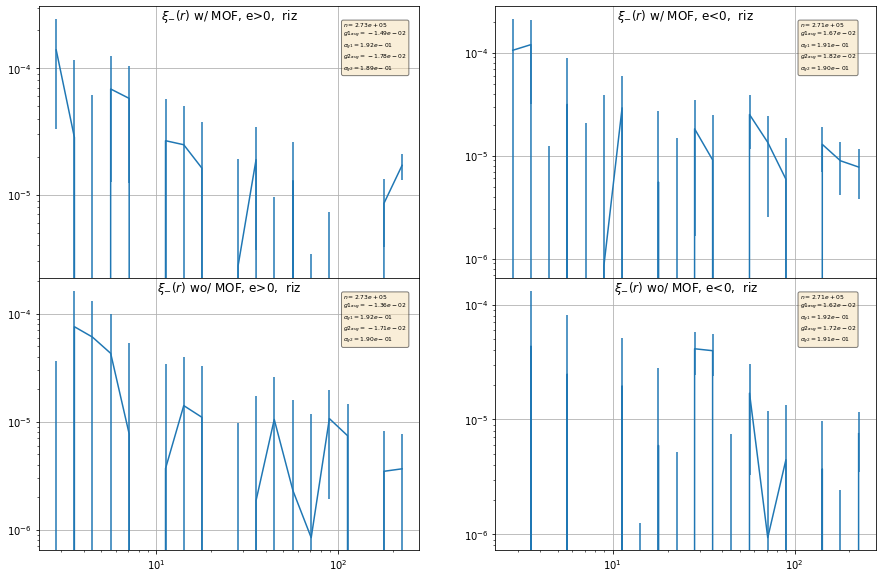

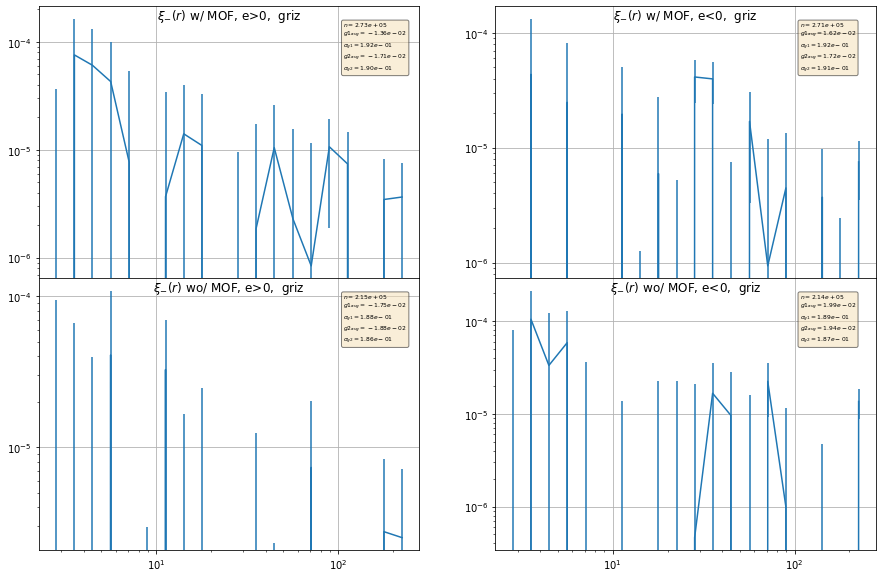

In [112]:
plt_gg_sub(gg_positive,gg_negative)

In [113]:
def plt_kg_sub(kg_positive,kg_negative):

    
    def get_plt_arguments(gg_dict):
        return({'x':np.exp(gg_dict['corrfunc'].meanlogr),'y':gg_dict['corrfunc'].xi,'yerr': np.sqrt(gg_dict['corrfunc'].varxi)})

    def get_plt_stats(gg):
        length=gg['length']
        kavg=gg['kaverage']
        ksig=gg['ksigma']
        g1avg = gg['g1avg']
        g1sigma=gg['g1sigma']


        textstr = '\n'.join((
            r'$n=%.2e$' % (length, ),
            r'$\kappa_{avg}=%.2e$' % (kavg, ),
            r'$\sigma_k=%.2e$' % (ksig, ),
            r'$g1_{avg}=%.2e$' % (g1avg, ),
            r'$\sigma_{g1}=%.2e$' % (g1sigma, )))
        return (textstr)
    
       # plot PM NM
        #      P  N
        #   1st xip     

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    for i in range(2):
    
        for key in key_list:
            pmof=kg_positive[i][key]
            p=kg_positive[i+1][key]
            nmof=kg_negative[i][key]
            n=kg_negative[i][key]

            fig, axs = plt.subplots(2,2)
            fig.set_figheight(10)
            fig.set_figwidth(15)
            for j,ax in enumerate(fig.axes):
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_title(r'KG $\xi(r)$ {} {} {}'.format(key,panel_title_list[j],band_str_list[i]), y=0.93)
            axs[0,0].errorbar(**get_plt_arguments(pmof))
            axs[0,0].text(0.85, 0.95, get_plt_stats(pmof), transform=axs[0,0].transAxes, fontsize=FONT_SIZE,
            verticalalignment='top', bbox=props)
            axs[0,1].errorbar(**get_plt_arguments(nmof))
            axs[0,1].text(0.85, 0.95, get_plt_stats(nmof), transform=axs[0,1].transAxes, fontsize=FONT_SIZE,
            verticalalignment='top', bbox=props)
            axs[1,0].errorbar(**get_plt_arguments(p))
            axs[1,0].text(0.85, 0.95, get_plt_stats(p), transform=axs[1,0].transAxes, fontsize=FONT_SIZE,
            verticalalignment='top', bbox=props)
            axs[1,1].errorbar(**get_plt_arguments(n))
            axs[1,1].text(0.85, 0.95, get_plt_stats(n), transform=axs[1,1].transAxes, fontsize=8,
            verticalalignment='top', bbox=props)
            plt.subplots_adjust(hspace=0)
            plt.savefig('/home/cz136/project/balrog/image/corr/subplots/KG/KG_{}_{}.png'.format(key,band_str_list[i]),dpi=500)
            plt.close()

In [114]:
plt_kg_sub(kg_positive,kg_negative);

## KE correlation

In [115]:
def get_ke(catalog,key):
    delta_g1=catalog['e_1'].to_numpy()
    delta_g2=catalog['e_2'].to_numpy()
    k=catalog[key].to_numpy()
    ra=catalog['ra'].to_numpy()
    dec=catalog['dec'].to_numpy()
    
    kcat= treecorr.Catalog( k=k,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    gcat = treecorr.Catalog( g1=delta_g1, g2=delta_g2,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    kg = treecorr.KGCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.2)
    kg.process(kcat,gcat)
    return(kg)

In [116]:
def get_ke_for_key(key):
    return (lambda df:get_ke(df,key))

def get_ke_for_indi_df(df):
    print(len(df))
    ke_dict={}
    for key in key_list:
        ke_dict[key]={"corrfunc":get_ke_for_key(key)(df),"length":len(df),"kaverage":np.mean(df[key]),"ksigma":np.std(df[key]),
                      'e1avg':np.mean(df['e_1']),'e1sigma':np.std(df['e_1']),'e2avg':np.mean(df['e_2']),'e2sigma':np.std(df['e_2'])} 
    return(ke_dict)

In [117]:
ke_positive=[get_ke_for_indi_df(df) for df in filled_df_positive]
ke_negative=[get_ke_for_indi_df(df) for df in filled_df_negative]

215727
215727
169940
169940
214531
214531
169167
169167


In [ ]:
ke_list = [get_ke_for_indi_df(df) for df in filled_df_list]

869585
869585


In [ ]:
def plt_no_slection_ke_sub(ke_list):
    wo_selection_titles=['MOF, ', 'woMOF, ']
    
    def get_plt_arguments(gg_dict):
        return({'x':np.exp(gg_dict['corrfunc'].meanlogr),'y':gg_dict['corrfunc'].xi,'yerr': np.sqrt(gg_dict['corrfunc'].varxi)})

    def get_plt_stats(gg):
        length=gg['length']
        kavg=gg['kaverage']
        ksig=gg['ksigma']
        e1avg = gg['e1avg']
        e1sigma=gg['e1sigma']
        e2avg = gg['e2avg']
        e2sigma=gg['e2sigma']


        textstr = '\n'.join((
            r'$n=%.2e$' % (length, ),
            r'$\kappa_{avg}=%.2e$' % (kavg, ),
            r'$\sigma_k=%.2e$' % (ksig, ),
            r'$e1_{avg}=%.2e$' % (e1avg, ),
            r'$\sigma_{e1}=%.2e$' % (e1sigma, ),
            r'$e2_{avg}=%.2e$' % (e2avg, ),
            r'$\sigma_{e1}=%.2e$' % (e2sigma, )))
        return (textstr)
    
       # plot PM NM
        #      P  N
        #   1st xip    
        
    FONT_SIZE=4

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    for i in range(2):
        for key in key_list:
            mof=ke_list[0][key]
            womof=ke_list[i+1][key]


            fig, axs = plt.subplots(2,1)
            fig.set_figheight(10)
            fig.set_figwidth(7)
            for j,ax in enumerate(fig.axes):
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_title(r'KE all $\xi(r)$ {} {} {}'.format(key,wo_selection_titles[j],band_str_list[i]), y=0.93)
            axs[0].errorbar(**get_plt_arguments(mof))
            axs[0].text(0.85, 0.95, get_plt_stats(mof), transform=axs[0].transAxes, fontsize=FONT_SIZE,
            verticalalignment='top', bbox=props)
            
            axs[1].errorbar(**get_plt_arguments(womof))
            axs[1].text(0.85, 0.95, get_plt_stats(womof), transform=axs[1].transAxes, fontsize=FONT_SIZE,
            verticalalignment='top', bbox=props)
            
            plt.subplots_adjust(hspace=0)
            plt.savefig('/home/cz136/project/balrog/image/corr/subplots/KE/all/KE_all_{}_{}.png'.format(key,band_str_list[i]),dpi=500)
            plt.close()

In [ ]:
plt_no_slection_ke_sub(ke_list);

In [ ]:
def subtract_median(df):
    for key in key_list:
        